In [176]:
import pandas as pd
import numpy as np
import math 
import scipy.stats as st

from sklearn.preprocessing import Normalizer


import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

In [177]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset

In [178]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device('cuda:0')
    from torch.cuda import FloatTensor, LongTensor
else:
    device = torch.device('cpu')
    from torch import FloatTensor, LongTensor
    
try:
    from google.colab import drive
    is_in_colab = True
except:
    is_in_colab = False
    

In [179]:
# вывод информации о выданном с colab GPU
if is_in_colab:
    !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
    !pip install gputil
    !pip install psutil
    !pip install humanize
    import psutil
    import humanize
    import os
    import GPUtil as GPU
    GPUs = GPU.getGPUs()
    gpu = GPUs[0]
    def printm():
        process = psutil.Process(os.getpid())
        print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
        print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

    printm()
    

In [180]:
if is_in_colab:
    drive.mount('/content/drive')
    data_folder = r'/content/drive/My Drive/Colab/IDAO_2020/'
else:
    data_folder = r'./data/'
    

In [181]:
# баш команда для создания каталога в монитрованном гугл-диске, для хранения там данных. 
# Выполните один раз после монтирования диска, чтобы не создавать папку вручную
# ! mkdir -p '/content/drive/My Drive/Colab/IDAO_2020/'


In [182]:
def save_model(path, model, optimizer, loss_history, train_history, val_history):
    torch.save({
            'epoch': len(train_histor),
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_history[-1],
            'loss_history': loss_history,
            'train_history': train_history,
            'val_history': val_history
            }, path)
    print('successfully saved')
    
def load_model(path, model, optimizer, loss_history, train_history, val_history):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss_history = checkpoint['loss_history']
    train_history = checkpoint['train_history']
    val_history = checkpoint['val_history']
    print('successfully loaded')

In [183]:
data = pd.read_csv(data_folder + 'train.csv', parse_dates=['epoch']).iloc[:,2:]

In [184]:
data.set_index(keys=data['sat_id'], inplace=True)

In [185]:
class Norm():
    """
    Нормализатор. 
    Init запоминает среднее и стандартное отклонение в данных
    """
    def __init__(self, data, ignore_column=None):
        self.mean = data.mean()
        self.std = data.std()
        self.l2 = data.pow(2, axis=0).sum(axis=0).pow(0.5, axis=0)
        if ignore_column:
            self.mean[ignore_column] = 0
            self.std[ignore_column] = 1
            self.l2[ignore_column] = 1
        
    def z_norm(self, data, columns=None):
        if not columns:
            columns = data.columns
        return (data[columns] - self.mean[columns]) / self.std[columns]
    
    def l2_norm(self, data, columns=None):
        if not columns:
            columns = data.columns
        return data[columns] / self.l2[columns]
        
    def back_z_norm(self, data, columns=None):
        try:
            if not columns:
                columns = data.columns
        except:
            print("data должен быть DataFrame или columns должен быть заполнен")
            return None
        if not type(data) is pd.core.frame.DataFrame:
            data = pd.DataFrame(data=data, columns=columns)
            
    def back_l2_norm(self, data, columns=None):
        try:
            if not columns:
                columns = data.columns
        except:
            print("data должен быть DataFrame или columns должен быть заполнен")
            return None
        if not type(data) is pd.core.frame.DataFrame:
            data = pd.DataFrame(data=data, columns=columns)
            
        return (data[columns] * self.l2[columns])

In [186]:
normalizer = Norm(data, ['sat_id'])
norm_data = normalizer.l2_norm(data)

In [187]:
np.random.seed(42)

def split_data(values, coeff=0.7):
    # coeff - доля трейна, остальное делится на валидацию и тест поровну
    split = int(np.floor(coeff * values))
    split2 = int(np.floor(values*(1-coeff)/2))
    indices = list(range(values))
    np.random.shuffle(indices)
    train_indices, val_indices, test_indices = indices[:split], indices[split:split+split2], indices[split+split2:]
    return train_indices, val_indices, test_indices

train_indices, val_indices, test_indices = split_data(len(data['sat_id'].unique()))

In [188]:
train_data = norm_data.loc[train_indices]
test_data = norm_data.loc[test_indices]
val_data = norm_data.loc[val_indices]

In [189]:
class Data_Sat(Dataset):
    def __init__(self, data, sequence_length=20):
        self.sequence_length = sequence_length
        self.data = data
        self.satellite_dict = {}
        self.normalizer = normalizer
        self.split_data()

    def split_data(self):
        # разделяет данные по каждому спутнику на отдельные секвенции длиной sequence_length каждая
        # и записывает их в словарь self.satellite_dict
        # нормализует данные

        for ind, satellite in enumerate(self.data['sat_id'].unique()):
            sat_data = self.data.query('sat_id==@satellite').iloc[:, 1:]
            sequence_count = np.ceil(sat_data.shape[0] / self.sequence_length).astype('int')

            samples_sat = np.zeros((sequence_count * self.sequence_length, 12))
            samples_sat[: sat_data.shape[0]] = sat_data.values

            self.satellite_dict[ind] = samples_sat.reshape(sequence_count, self.sequence_length, 12)

    def generate_samples(self, max_sequence_count=10, last_sequence=False):
        # генерирует отдельные наборы последовательных секвенций, аугментируя данные: 
        # разбивает данные по одному спутнику (если их больше, чем max_sequence_count)
        # на несколько отдельных последовательностей 
        # для использования их при тренировке, как разных спутников.
        self.samples = []
        

        for sat in self.satellite_dict.values():
            sequence_count = sat.shape[0]
            if not last_sequence:
                sequence_count -= 1
            if  sequence_count > max_sequence_count:
                samples_count = math.ceil(sequence_count / max_sequence_count)
                step = (sequence_count - max_sequence_count) / (samples_count - 1)
                for sample in range(samples_count):
                    next_step = round(step * sample)
                    self.samples.append(self.data_casting(sat[next_step: next_step + max_sequence_count]))

    @staticmethod
    def data_casting(data):
        # вычитает из значений симуляции начальную ошибку.
        # начальная ошибка равна x_sym[0] - x[0] и аналогично для y, z и т.д.
        for i in range(6):
            data[..., i + 6] -= data[0, 0, i + 6] - data[0, 0, i]
        return data

    def __len__(self):
        """
        Returns total number of samples
        """
        return len(self.samples)

    def __getitem__(self, index):
        """
        
        :param index: 
        :return: one-satellite sample [max_sequence_count, sequence_length, gt + in values]
        """
        return FloatTensor(self.samples[index])
    

In [190]:
import math
from tqdm import tqdm


def do_epoch(model, loss_function, data, batch_size, optimizer=None, name=None):
    epoch_loss = 0
    epoch_SGP4_loss = 0
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    max_sequence_count, sequence_length = data[0].shape[0], data[0].shape[1]
    batch_count = len(loader)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batch_count) as progress_bar:
            for i, sample in enumerate(loader):
                sample = sample.permute(1, 2, 0, 3)  # [max_sequence_count, sequence_length,  batch, gt + in values]
                previous_predicts = torch.zeros(sequence_length, sample.shape[2], 6).to(device)
                for sequence in sample:
                    X_batch, y_batch = (sequence[...,6:]).to(device), (sequence[...,:6]).to(device)
                    inputs = torch.cat((X_batch, previous_predicts), dim=-1)
                    
                    prediction = model(inputs)
                    
                    loss = loss_function(prediction, y_batch)
                    SGP4_loss = loss_function(X_batch, y_batch)
                    
                    epoch_loss += loss.item()
                    epoch_SGP4_loss += SGP4_loss.item()

                    if is_train:
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        
                    previous_predicts[0] = prediction[-1].detach()
                

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}'.format(
                    name, loss.item())
                )
            
            epoch_loss /= (i + 1) * max_sequence_count
            epoch_SGP4_loss /= (i + 1) * max_sequence_count
            loss_comparison = epoch_loss / epoch_SGP4_loss
            
            progress_bar.set_description(f'Epoch {name} - loss compar: {loss_comparison:.2f}, '
                                         f'loss: {epoch_loss:.5f}, SGP4 loss: {epoch_SGP4_loss:.5f}')

    return loss_comparison


def fit(model, loss_function, optimizer=None, train_data=None, epochs_count=1, batch_size=1,
        val_data=None, val_batch_size=None, plot_draw=False):
    """
    тренировко модели с валидацией после каждой эпохи, если валидация задана
    """
    train_history = []
    val_history = []
        
    if val_data and val_batch_size is None:
        val_batch_size = batch_size
        
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        if train_data:
            train_history.append(do_epoch(model, loss_function, train_data, batch_size, 
                                          optimizer, name_prefix + 'Train:')
                                )

        if val_data:
            name = '  Val:'
            if not train_data:
                name = ' Test:'
            val_history.append(do_epoch(model, loss_function, val_data, val_batch_size, 
                                         optimizer=None, name=name_prefix + name)
                             )
    if plot_draw:
        draw_plot(train_history, val_history)  

In [191]:
def draw_plot(train_loss_history, val_loss_history):
    """
    Рисует lineplot
    """
    data = pd.DataFrame(data=[train_loss_history, val_loss_history], index=['Train', 'Val']).T
    plt.figure(figsize=(15, 6))
    sns.set(style='darkgrid')
    ax = sns.lineplot(data=data, markers = ["o", "o"], palette='bright')
    plt.title("Line Plot", fontsize = 20)
    plt.xlabel("Epoch", fontsize = 15)
    plt.ylabel("Loss", fontsize = 15)
    plt.show()

In [192]:
class LSTM(nn.Module):
    def __init__(self, input_dim=12, output_dim=6, lstm_hidden_dim=20, 
                 lstm_layers_count=1, bidirectional=False, dropout=0
                ):
        super().__init__()
        
        self.lstm_layers_count = lstm_layers_count
        self.lstm_hidden_dim = lstm_hidden_dim
        
        self.lstm = nn.LSTM(input_size = input_dim, 
                            hidden_size = lstm_hidden_dim,
                            num_layers = lstm_layers_count,
                            bidirectional=bidirectional,
                            bias=True,
                            dropout=dropout
                           )
        
        self.linear = nn.Linear(lstm_hidden_dim, output_dim, bias=True)
        
    #def init_hidden(self, batch_size):
            #return (torch.zeros(self.lstm_layers_count * (2 if bidirectional else 1), batch_size, self.lstm_hidden_dim).to(device),
                    #torch.zeros(self.lstm_layers_count * (2 if bidirectional else 1), batch_size, self.lstm_hidden_dim).to(device))

    #def forward(self, inputs, h, c):
    def forward(self, inputs):
        #lstm_out, _ = self.lstm.forward(inputs, (h, c))
        lstm_out, _ = self.lstm.forward(inputs)
        linear_out = self.linear.forward(lstm_out)
        return linear_out


In [193]:
# data settings
sequence_length = 20
max_sequence_count = 100

# train settings
batch_size = 5
epoch_count = 10
plot_draw = True

# optimizer settings
learning_rate = 1e-4
weight_decay = 0

# model settings
lstm_hidden_dim = 20
lstm_hidden_lauers_count = 1
bidirectional = False
dropout = 0

train_dataset = Data_Sat(train_data, sequence_length)
train_dataset.generate_samples(max_sequence_count=max_sequence_count, last_sequence=False)
val_dataset = Data_Sat(val_data, sequence_length)
val_dataset.generate_samples(max_sequence_count=max_sequence_count,  last_sequence=False)
print('Samples count:', len(train_dataset))

model = LSTM(lstm_hidden_dim=lstm_hidden_dim,
             lstm_layers_count=lstm_hidden_lauers_count,
             bidirectional=bidirectional,
             dropout=dropout
            ).to(device)

loss_function = torch.nn.MSELoss()
optimizer = optim.Adam(
                        model.parameters(),
                        lr=learning_rate, 
                        weight_decay=weight_decay
                    )

Samples count: 143


Epoch [1 / 10] Train: - loss compar: 781.13, loss: 0.00060, SGP4 loss: 0.00000: 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]
Epoch [1 / 10]   Val: - loss compar: 138.05, loss: 0.00004, SGP4 loss: 0.00000: 100%|██████████| 6/6 [00:00<00:00,  7.48it/s]
Epoch [2 / 10] Train: - loss compar: 18.41, loss: 0.00001, SGP4 loss: 0.00000: 100%|██████████| 29/29 [00:15<00:00,  1.84it/s]
Epoch [2 / 10]   Val: - loss compar: 10.32, loss: 0.00000, SGP4 loss: 0.00000: 100%|██████████| 6/6 [00:00<00:00,  7.21it/s]
Epoch [3 / 10] Train: - loss compar: 1.99, loss: 0.00000, SGP4 loss: 0.00000: 100%|██████████| 29/29 [00:15<00:00,  1.84it/s]
Epoch [3 / 10]   Val: - loss compar: 3.64, loss: 0.00000, SGP4 loss: 0.00000: 100%|██████████| 6/6 [00:00<00:00,  7.75it/s]
Epoch [4 / 10] Train: - loss compar: 1.17, loss: 0.00000, SGP4 loss: 0.00000: 100%|██████████| 29/29 [00:15<00:00,  1.82it/s]
Epoch [4 / 10]   Val: - loss compar: 2.61, loss: 0.00000, SGP4 loss: 0.00000: 100%|██████████| 6/6 [00:00<00:00,  7.09

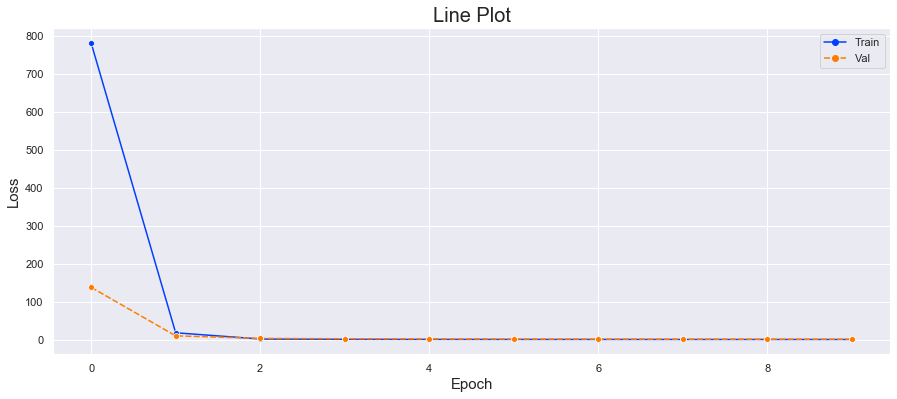

In [194]:
# run with validation
fit(model, loss_function, optimizer, train_dataset, epochs_count=epoch_count,
    batch_size=batch_size, val_data=val_dataset, plot_draw=plot_draw
   )

In [195]:
test_dataset = Data_Sat(test_data, sequence_length)
test_dataset.generate_samples(max_sequence_count=100)

In [196]:
fit(model, loss_function, val_data=test_dataset)

Epoch [1 / 1]  Test: - loss compar: 0.91, loss: 0.00000, SGP4 loss: 0.00000: 100%|██████████| 30/30 [00:04<00:00,  7.22it/s]


In [202]:
def smape(satellite_predicted_values, satellite_true_values): 
    # the division, addition and subtraction are pointwise 
    return np.mean(np.abs((satellite_predicted_values - satellite_true_values) 
        / (np.abs(satellite_predicted_values) + np.abs(satellite_true_values))))

def predict(model, sat_data, test=False):
    sequences_count, sequence_length, values = sat_data.shape
    result = np.zeros((sequences_count*sequence_length, 6))
    previous_predicts = torch.zeros(sequence_length, 1, 6).to(device)
    for i, seq in enumerate(sat_data):
        inputs = seq[:,None,(0 if test else 6):]
        inputs = torch.cat((FloatTensor(inputs), previous_predicts), dim=-1)
        predicted = model(inputs)  
        previous_predicts[0] = predicted[-1].detach()
        predicted = predicted.view(sequence_length, 6).cpu().detach().numpy()
        result[i*sequence_length : (i+1)*sequence_length, :] = predicted
    return result[sat_data.reshape(-1, sat_data.shape[2])[:,:6] != 0 ].reshape(-1, 6)

metric = 0
for sat in test_dataset.satellite_dict:
    sat_data = test_dataset.satellite_dict[sat]
    metric += smape(predict(model, sat_data), 
                    sat_data[:,:,:6][sat_data[:,:,:6]!=0].reshape(-1, 6)
                   )
metric /= len(test_dataset.satellite_dict)
score = (1-metric)*100

In [203]:
score

49.973675637720824